# Gesture Recognition using Two-Stream Temporal Convolutional Network (2S-TCN)

**2S-TCN** is a lightweight, fast model designed for recognizing gestures by learning temporal patterns in skeleton sequences. It uses 1D temporal convolutions to capture motion over time and integrates a **dual-stream** architecture: one stream for raw **joint** coordinates and another for **bone** vectors (relative motion between joints). This enhances its understanding of movement dynamics, but it lacks spatial awareness across joints, which can lead to confusion between similar actions.

This project supports gesture-based communication between humans and robots in real-world environments like retail, manufacturing, or healthcare where hands-free interaction is more effective.

## Code to convert skeleton files to numpy arrays:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
import os
import zipfile
import gdown

# Setup
file_id = '1gBjOq3tdmm8GITCf0iLX6XBjEdSPMj5Q'
zip_filename = 'DL_Data_Conversion_Chi.zip'
extract_dir = 'skeleton_dataset'        # folder to extract to

# Download if not already present
if not os.path.exists(zip_filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, zip_filename, quiet=False)

# Unzip if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print(f"✅ Dataset ready at: {extract_dir}/")


✅ Dataset ready at: skeleton_dataset/


In [53]:
from pathlib import Path
import numpy as np
import json
from collections import defaultdict

def parse_skeleton_file_to_dict(file_path, max_body=4, njoints=25):
    with open(file_path, 'r') as f:
        datas = f.readlines()

    nframe = int(datas[0])
    if nframe == 0:
        return None

    bodymat = {
        'file_name': file_path.stem,
        'nbodys': [],
        'njoints': njoints
    }

    for body in range(max_body):
        bodymat[f'skel_body{body}'] = np.zeros((nframe, njoints, 3))
        bodymat[f'depth_body{body}'] = np.zeros((nframe, njoints, 2))
        bodymat[f'rgb_body{body}'] = np.zeros((nframe, njoints, 2))

    cursor = 0
    for frame in range(nframe):
        cursor += 1
        if cursor >= len(datas): break

        bodycount = int(datas[cursor])
        if bodycount == 0:
            continue

        bodymat['nbodys'].append(bodycount)

        for body in range(bodycount):
            cursor += 2  # skip 2 lines (body ID and metadata)
            if cursor >= len(datas): break

            joint_count = int(datas[cursor])
            for joint in range(joint_count):
                cursor += 1
                if cursor >= len(datas): break

                jointinfo = list(map(float, datas[cursor].split()))
                if joint < njoints:
                    bodymat[f'skel_body{body}'][frame, joint] = jointinfo[0:3]
                    bodymat[f'depth_body{body}'][frame, joint] = jointinfo[3:5]
                    bodymat[f'rgb_body{body}'][frame, joint] = jointinfo[5:7]

    # Remove unused bodies
    for body in range(max_body):
        if body >= max(bodymat['nbodys'], default=0):
            bodymat.pop(f'skel_body{body}', None)
            bodymat.pop(f'depth_body{body}', None)
            bodymat.pop(f'rgb_body{body}', None)

    return bodymat

def convert_skeletons_and_create_metadata(input_folder, output_folder, metadata_path=None, missing_file_list=None, max_files=None):
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    if missing_file_list:
        with open(missing_file_list, 'r') as f:
            missing = {line.strip() for line in f}
    else:
        missing = set()

    metadata = {}
    class_counts = defaultdict(int)
    file_count = 0

    for file_path in sorted(input_path.rglob("*.skeleton")):
        file = file_path.name
        file_id = file[:20]
        if file_id in missing:
            print(f"❌ Skipping missing: {file}")
            continue

        if max_files is not None and file_count >= max_files:
            break

        out_file = f"{file}.npy"
        save_path = output_path / out_file

        # ✅ Always overwrite
        if save_path.exists():
            os.remove(save_path)

        data = parse_skeleton_file_to_dict(file_path)
        if data is None or 'skel_body0' not in data:
            print(f"⚠️ Skipping {file}: missing or invalid skeleton data")
            continue

        try:
            label = int(file.split('A')[1][:3]) - 1
            data['label'] = label
            np.save(save_path, data)
            metadata[out_file] = label
            class_counts[label] += 1
        except Exception as e:
            print(f"❗ Could not parse label for {file}: {e}")
            continue

        file_count += 1

    if metadata_path:
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"📄 Metadata saved to: {metadata_path}")

    print(f"\n✅ Done: {file_count} files processed.")
    print("\n📊 Final class distribution:")
    for cls, count in sorted(class_counts.items()):
        print(f"  Class {cls:2d}: {count} samples")

    return metadata if metadata_path else None


In [54]:
for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if name.endswith(".skeleton"):
            print(os.path.join(root, name))
            break


./skeleton_dataset/DL_Data_Conversion_Chi/data/S005C003P017R002A006.skeleton


In [55]:
convert_skeletons_and_create_metadata(
    input_folder='skeleton_dataset',
    output_folder='/content/skeleton_dataset/converted',
    metadata_path='/content/skeleton_dataset/metadata.json',
    max_files=None
)


⚠️ Skipping S001C002P006R001A008.skeleton: missing or invalid skeleton data
⚠️ Skipping S001C003P005R002A004.skeleton: missing or invalid skeleton data
⚠️ Skipping S001C003P005R002A005.skeleton: missing or invalid skeleton data
⚠️ Skipping S001C003P005R002A006.skeleton: missing or invalid skeleton data
⚠️ Skipping S002C002P011R002A030.skeleton: missing or invalid skeleton data
⚠️ Skipping S002C003P011R002A011.skeleton: missing or invalid skeleton data
⚠️ Skipping S003C003P018R002A024.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P003R001A013.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P008R001A009.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P020R001A003.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P020R001A004.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P020R001A012.skeleton: missing or invalid skeleton data
⚠️ Skipping S004C002P020R001A020.skeleton: missing or invalid skeleton data
⚠️ Skipping 

{'S001C001P001R001A001.skeleton.npy': 0,
 'S001C001P001R001A002.skeleton.npy': 1,
 'S001C001P001R001A003.skeleton.npy': 2,
 'S001C001P001R001A004.skeleton.npy': 3,
 'S001C001P001R001A005.skeleton.npy': 4,
 'S001C001P001R001A006.skeleton.npy': 5,
 'S001C001P001R001A007.skeleton.npy': 6,
 'S001C001P001R001A008.skeleton.npy': 7,
 'S001C001P001R001A009.skeleton.npy': 8,
 'S001C001P001R001A010.skeleton.npy': 9,
 'S001C001P001R001A011.skeleton.npy': 10,
 'S001C001P001R001A012.skeleton.npy': 11,
 'S001C001P001R001A013.skeleton.npy': 12,
 'S001C001P001R001A014.skeleton.npy': 13,
 'S001C001P001R001A015.skeleton.npy': 14,
 'S001C001P001R001A016.skeleton.npy': 15,
 'S001C001P001R001A017.skeleton.npy': 16,
 'S001C001P001R001A018.skeleton.npy': 17,
 'S001C001P001R001A019.skeleton.npy': 18,
 'S001C001P001R001A020.skeleton.npy': 19,
 'S001C001P001R001A021.skeleton.npy': 20,
 'S001C001P001R001A022.skeleton.npy': 21,
 'S001C001P001R001A023.skeleton.npy': 22,
 'S001C001P001R001A024.skeleton.npy': 23,
 '

In [40]:
import shutil
shutil.move('/content/skeleton_dataset/DL_Data_Conversion_Chi/parsed_data/metadata.json', '/skeleton_dataset/metadata.json')

'/skeleton_dataset/metadata.json'

## Now parse all files and assign labels (based on action ID in filename):

In [69]:
import torch
from torch.utils.data import Dataset
from pathlib import Path

class SkeletonDatasetCTR(Dataset):
    def __init__(self, data_dir, metadata_path=None, target_frames=50):
        self.data_dir = Path(data_dir)
        self.target_frames = target_frames
        self.metadata_path = metadata_path

        if self.metadata_path:
            with open(self.metadata_path, 'r') as f:
                self.metadata = json.load(f)
            self.files = list(self.metadata.keys())
        else:
            self.metadata = None
            self.files = [f.name for f in self.data_dir.glob('*.npy')]

    def center_skeleton(self, skel):
        center = skel[:, 0:1, :]
        return skel - center

    def normalize_skeleton(self, skel):
        max_val = np.max(np.abs(skel))
        return skel / (max_val + 1e-5)

    def sample_frames(self, skel):
        n_frames = skel.shape[0]
        if n_frames == self.target_frames:
            return skel
        elif n_frames > self.target_frames:
            idx = np.linspace(0, n_frames - 1, self.target_frames).astype(int)
            return skel[idx]
        else:
            pad = np.repeat(skel[-1:], self.target_frames - n_frames, axis=0)
            return np.concatenate([skel, pad], axis=0)

    def reshape_for_ctr(self, skel):
        skel = skel.reshape(self.target_frames, 25, 3)
        return np.transpose(skel, (2, 0, 1))  # (C, T, V)

    def __len__(self):
        return len(self.files)

    def compute_bone_stream(self, skel):
     bone_pairs = [
        (1, 0), (2, 1), (3, 2), (4, 3),
        (5, 0), (6, 5), (7, 6), (8, 7),
        (9, 0), (10, 9), (11, 10), (12, 11),
        (13, 0), (14, 13), (15, 14), (16, 15),
        (17, 0), (18, 17), (19, 18), (20, 19),
        (21, 0), (22, 21), (23, 22), (24, 23)
     ]
     bone = np.zeros_like(skel)
     for j1, j2 in bone_pairs:
        bone[:, j1, :] = skel[:, j1, :] - skel[:, j2, :]
     return bone

    def __getitem__(self, idx):
      file_name = self.files[idx]
      skeleton = np.load(self.data_dir / file_name, allow_pickle=True).item()

      skel = skeleton['skel_body0']
      label = skeleton['label'] if self.metadata is None else self.metadata[file_name]

      skel = self.center_skeleton(skel)
      skel = self.normalize_skeleton(skel)
      skel = self.sample_frames(skel)

    # Augmentations
      if np.random.rand() < 0.3:
          skel += np.random.normal(0, 0.02, skel.shape)
      if np.random.rand() < 0.3:
          shuffle_idx = np.random.permutation(self.target_frames)
          skel = skel[shuffle_idx]
      if np.random.rand() < 0.2:
          skel *= (0.9 + 0.2 * np.random.rand())

      joint_stream = self.reshape_for_ctr(skel)  # (3, T, V)
      bone_stream = self.reshape_for_ctr(self.compute_bone_stream(skel))  # (3, T, V)

      return (
          torch.tensor(joint_stream, dtype=torch.float32),
          torch.tensor(bone_stream, dtype=torch.float32),
         torch.tensor(label, dtype=torch.long)
      )


In [71]:
skeleton_files = list(Path("skeleton_dataset").rglob("*.skeleton"))
print(f"Found {len(skeleton_files)} skeleton files")
if skeleton_files:
    print("Example file path:", skeleton_files[0])


Found 56880 skeleton files
Example file path: skeleton_dataset/DL_Data_Conversion_Chi/data/S005C003P017R002A006.skeleton


# **TCN**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TCNModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=60, num_joints=25, num_frames=50):
        super(TCNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.tcn1 = nn.Conv2d(64, 128, kernel_size=(9, 1), padding=(4, 0))
        self.bn2 = nn.BatchNorm2d(128)

        self.tcn2 = nn.Conv2d(128, 256, kernel_size=(9, 1), padding=(4, 0))
        self.bn3 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(p=0.3)  # Dropout before flattening

        self.dropout = nn.Dropout(p=0.3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # NEW: Global Average Pooling
        self.fc = nn.Linear(256, num_classes)  # Changed from flattened 320k+ vector

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.stgcn1(x)))
        x = F.relu(self.bn3(self.stgcn2(x)))
        x = self.dropout(x)              # Apply dropout before flattening
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)        # Flatten
        x = self.fc(x)
        return x


In [ ]:
class TwoStreamTCN(nn.Module):
    def __init__(self, base_model_cls, num_classes=60):
        super().__init__()
        self.joint_model = base_model_cls(num_classes=num_classes)
        self.bone_model = base_model_cls(num_classes=num_classes)
        self.fc_fuse = nn.Linear(2 * num_classes, num_classes)

    def forward(self, joint_x, bone_x):
        joint_out = self.joint_model(joint_x)
        bone_out = self.bone_model(bone_x)
        combined = torch.cat((joint_out, bone_out), dim=1)
        return self.fc_fuse(combined)


In [74]:
import os

directory = '/skeleton_dataset/converted/'
file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"Number of files in '{directory}': {file_count}")

Number of files in '/skeleton_dataset/converted/': 56715


In [83]:
import os
import json

data_dir = "/skeleton_dataset/converted/"
metadata = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".npy"):
        try:
            # Assume label can be parsed from filename (as in previous snippets)
            label = int(filename.split('A')[1][:3]) - 1
            metadata[filename] = label
        except Exception as e:
            print(f"Could not parse label for {filename}: {e}")
            # Decide how to handle these, maybe assign a default label or skip them

with open("/skeleton_dataset/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import json

# Hyperparameters
batch_size = 64
epochs = 100
learning_rate = 0.01
val_split = 0.2
num_classes = 60

# Load dataset
full_dataset = SkeletonDatasetTCN("/skeleton_dataset/converted/", metadata_path="/skeleton_dataset/metadata.json")
val_size = int(len(full_dataset) * val_split)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False, num_workers=2, pin_memory=True)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoStreamTCN(CTRGCNModel, num_classes=60).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Enable label smoothing
optimizer = optim.AdamW(model.parameters(), lr= learning_rate, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs,pct_start=0.3, anneal_strategy='cos')


In [96]:
print(f"Train dataset size: {len(full_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 56715
Validation dataset size: 11343


In [97]:
def train(model, loader):
    model.train()
    total_loss, correct = 0.0, 0
    for joint_x, bone_x, y in loader:
        joint_x, bone_x, y = joint_x.to(device), bone_x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(joint_x, bone_x)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += (out.argmax(dim=1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for joint_x, bone_x, y in loader:
            joint_x, bone_x, y = joint_x.to(device), bone_x.to(device), y.to(device)
            out = model(joint_x, bone_x)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            correct += (out.argmax(dim=1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [98]:
import csv
import os
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

best_val_acc = 0
patience = 20
patience_counter = 0

# --- Setup CSV logging ---
log_file_path = "Chi_training_log.csv"
os.makedirs("logs", exist_ok=True)
log_file = open(log_file_path, mode='w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", "Learning Rate"])

# --- Training loop ---
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Log to CSV per epoch
    log_writer.writerow([epoch+1, train_loss, val_loss, train_acc, val_acc, learning_rates[-1]])

    # Display
    print(f"📅 Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ctr_two_stream_model.pth")
        print("✅ Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("🛑 Early stopping: no improvement after", patience, "epochs.")
            break

# --- Finish ---
log_file.close()
print("🎉 Training complete!")


📅 Epoch 1/100 | Train Loss: 3.4023, Acc: 0.1663 | Val Loss: 3.1256, Acc: 0.2324
✅ Best model saved!
📅 Epoch 2/100 | Train Loss: 2.9964, Acc: 0.2722 | Val Loss: 2.9509, Acc: 0.2803
✅ Best model saved!
📅 Epoch 3/100 | Train Loss: 2.8651, Acc: 0.3110 | Val Loss: 2.8123, Acc: 0.3259
✅ Best model saved!
📅 Epoch 4/100 | Train Loss: 2.7601, Acc: 0.3491 | Val Loss: 2.8051, Acc: 0.3262
✅ Best model saved!
📅 Epoch 5/100 | Train Loss: 2.6710, Acc: 0.3718 | Val Loss: 2.7315, Acc: 0.3330
✅ Best model saved!
📅 Epoch 6/100 | Train Loss: 2.5957, Acc: 0.3971 | Val Loss: 2.5688, Acc: 0.4048
✅ Best model saved!
📅 Epoch 7/100 | Train Loss: 2.5405, Acc: 0.4151 | Val Loss: 2.5118, Acc: 0.4271
✅ Best model saved!
📅 Epoch 8/100 | Train Loss: 2.4979, Acc: 0.4296 | Val Loss: 2.4796, Acc: 0.4322
✅ Best model saved!
📅 Epoch 9/100 | Train Loss: 2.4524, Acc: 0.4414 | Val Loss: 2.4598, Acc: 0.4377
✅ Best model saved!
📅 Epoch 10/100 | Train Loss: 2.4265, Acc: 0.4521 | Val Loss: 2.4450, Acc: 0.4434
✅ Best model saved!

# **EVALUATION**

<ipython-input-99-4140630efb73>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


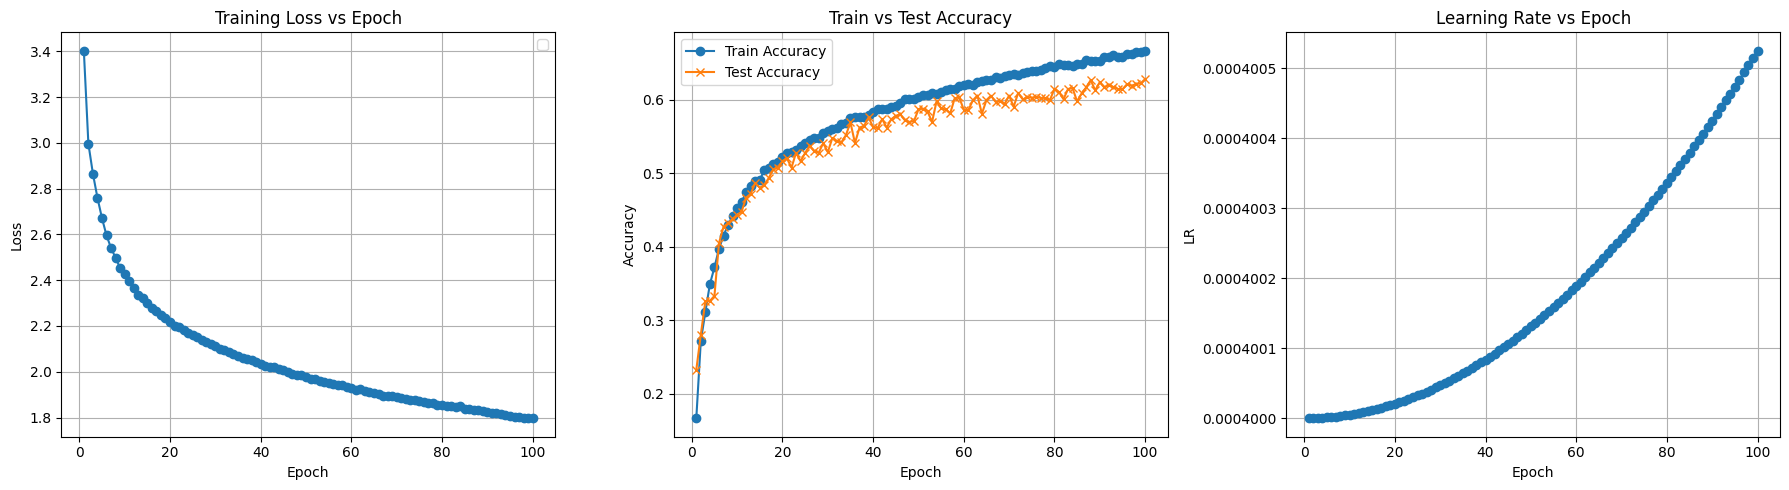

In [99]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18, 5))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, marker = 'o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.grid()

# Accuracy Curve
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Test Accuracy', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid()

# Learning Rate Curve
plt.subplot(1, 3, 3)
plt.plot(epochs_range, learning_rates, label='Learning Rate', marker='o')
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate vs Epoch")
plt.grid()

plt.tight_layout()
plt.savefig("logs/training_curves.png")
plt.show()

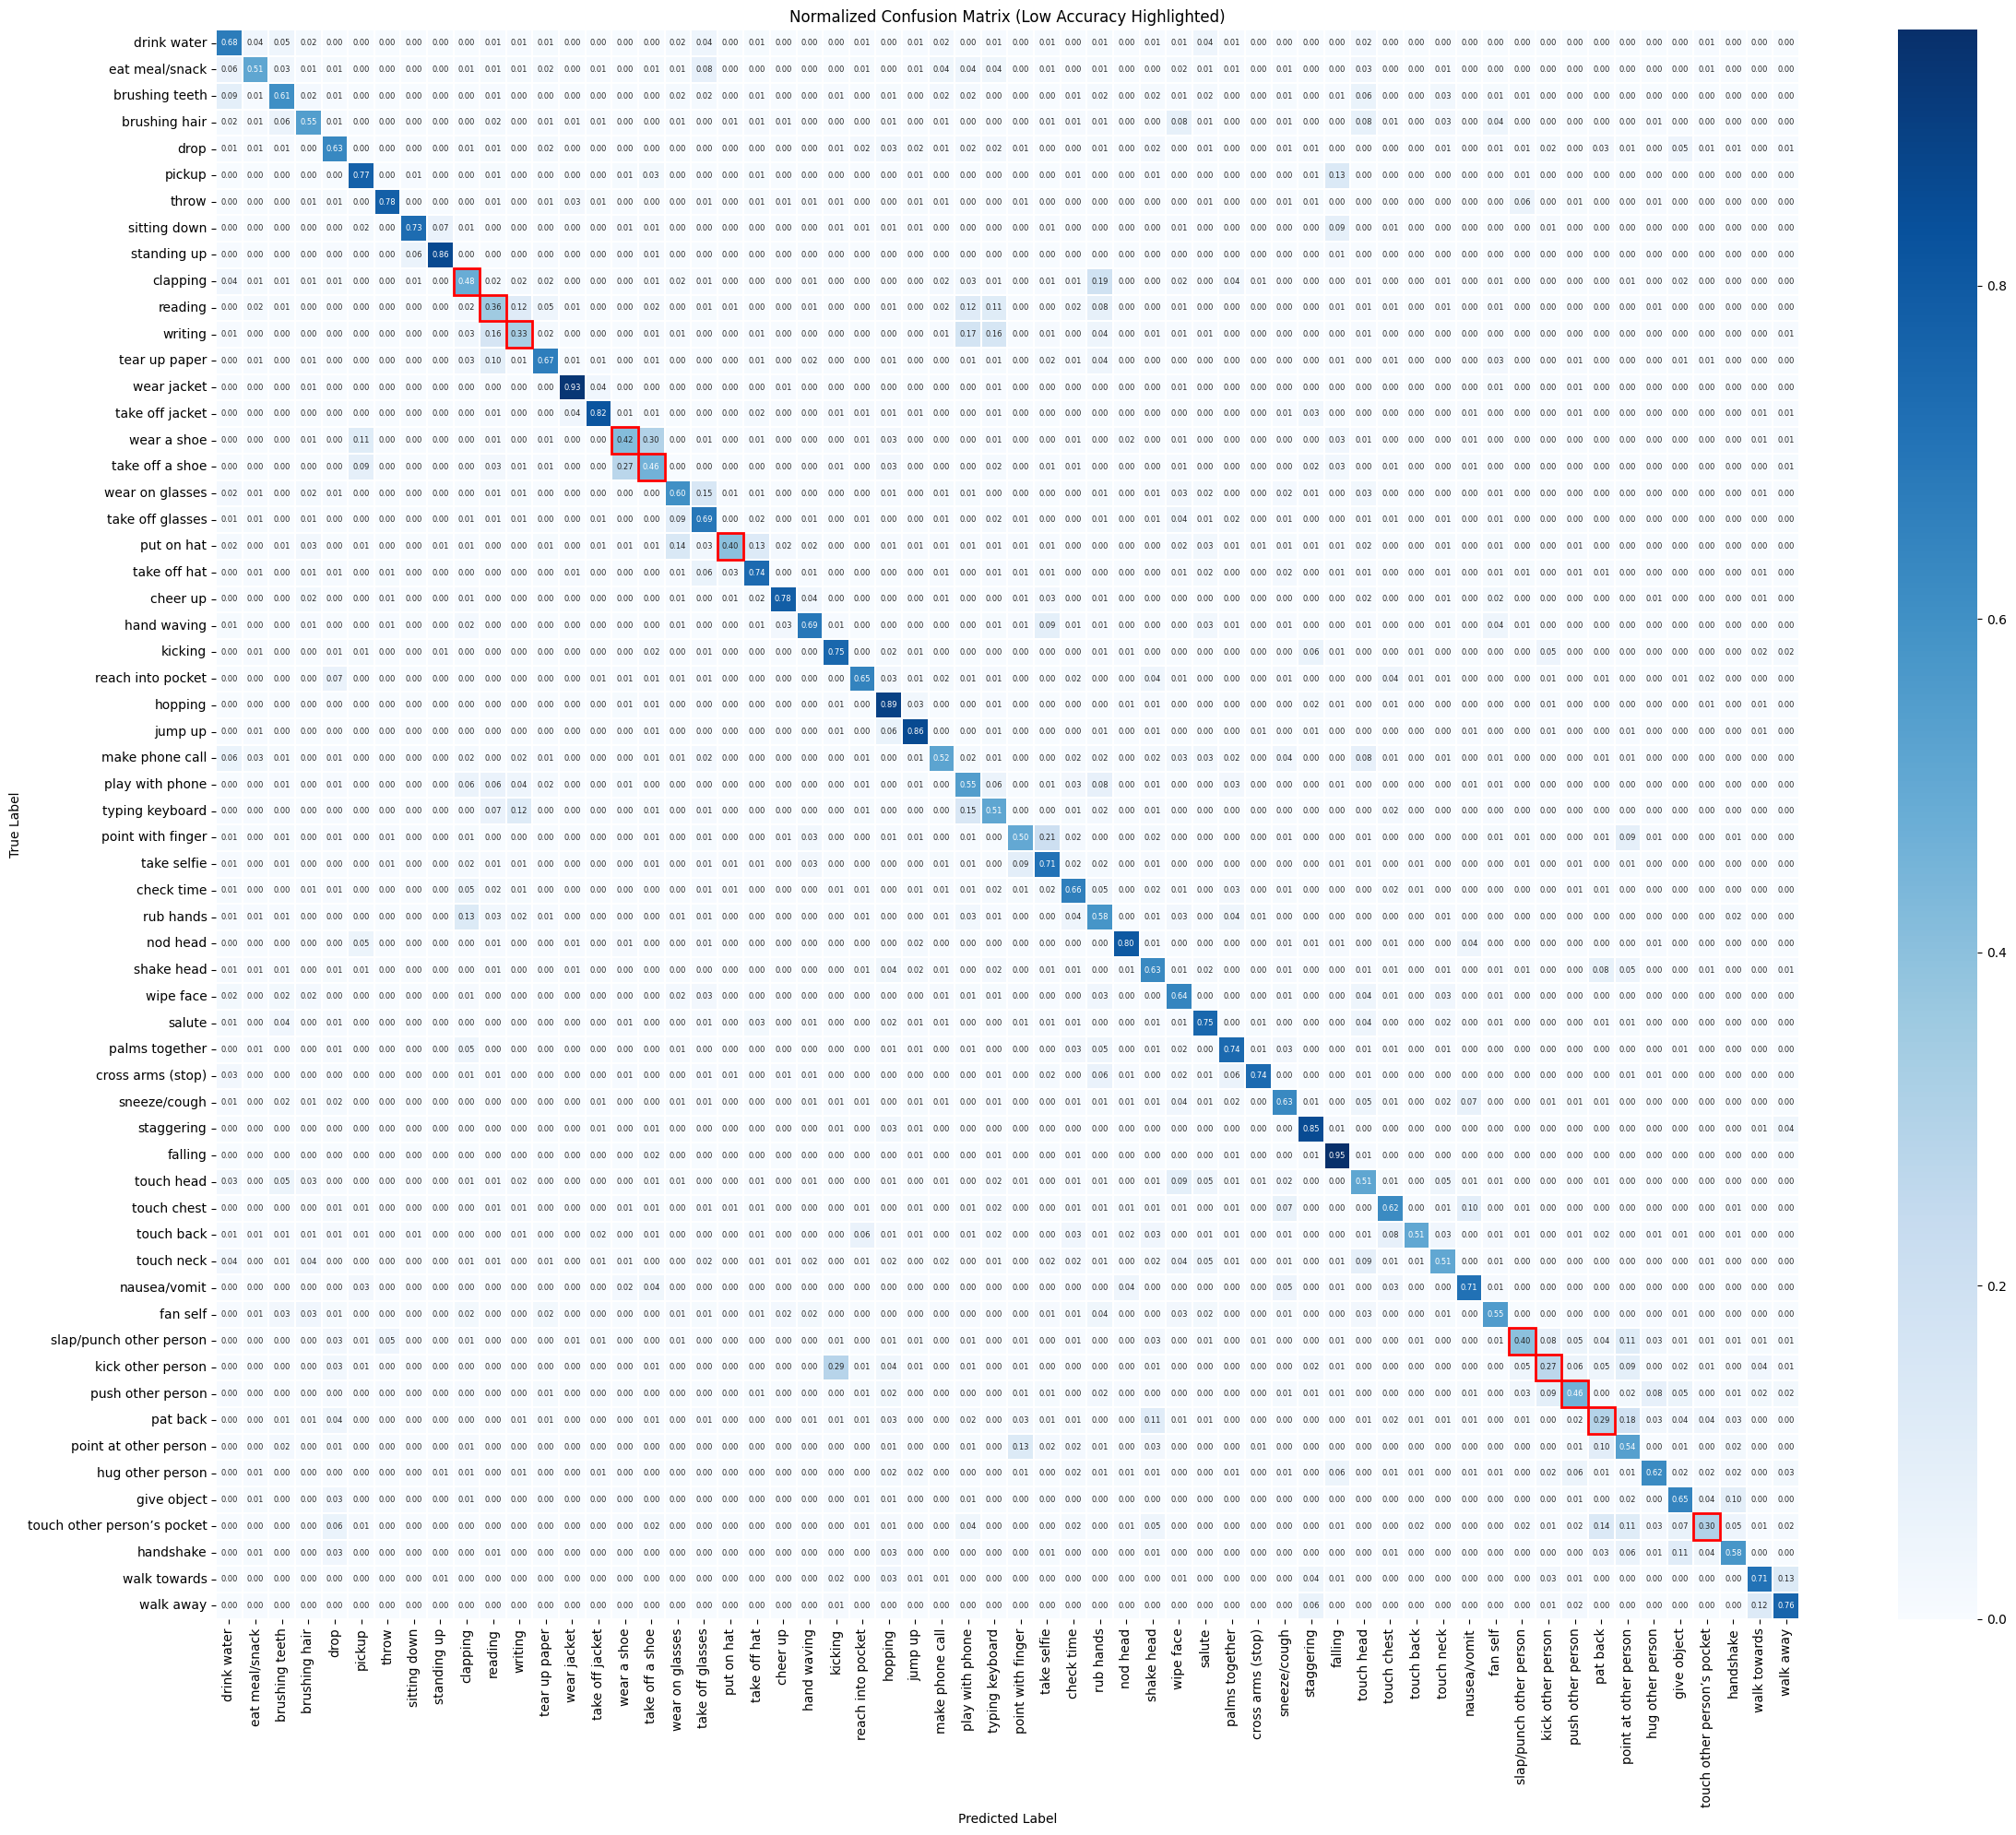


Per-Class Recall (%):
drink water: 67.54%
eat meal/snack: 51.34%
brushing teeth: 60.51%
brushing hair: 54.71%
drop: 63.04%
pickup: 77.20%
throw: 78.19%
sitting down: 73.21%
standing up: 86.27%
clapping: 48.48%
reading: 35.75%
writing: 33.13%
tear up paper: 67.03%
wear jacket: 92.93%
take off jacket: 81.82%
wear a shoe: 42.05%
take off a shoe: 46.07%
wear on glasses: 60.33%
take off glasses: 69.11%
put on hat: 39.89%
take off hat: 73.96%
cheer up: 78.36%
hand waving: 69.15%
kicking: 75.00%
reach into pocket: 65.09%
hopping: 89.23%
jump up: 85.86%
make phone call: 52.02%
play with phone: 54.84%
typing keyboard: 51.20%
point with finger: 50.00%
take selfie: 70.88%
check time: 66.32%
rub hands: 58.29%
nod head: 80.12%
shake head: 62.78%
wipe face: 64.08%
salute: 75.00%
palms together: 74.27%
cross arms (stop): 74.07%
sneeze/cough: 62.83%
staggering: 85.38%
falling: 95.36%
touch head: 51.08%
touch chest: 62.00%
touch back: 50.58%
touch neck: 50.52%
nausea/vomit: 71.29%
fan self: 55.34%
sla

In [100]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ NTU60 gesture labels (A001 to A060)
gesture_names = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop",
    "pickup", "throw", "sitting down", "standing up", "clapping",
    "reading", "writing", "tear up paper", "wear jacket", "take off jacket",
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on hat",
    "take off hat", "cheer up", "hand waving", "kicking", "reach into pocket",
    "hopping", "jump up", "make phone call", "play with phone", "typing keyboard",
    "point with finger", "take selfie", "check time", "rub hands", "nod head",
    "shake head", "wipe face", "salute", "palms together", "cross arms (stop)",
    "sneeze/cough", "staggering", "falling", "touch head", "touch chest",
    "touch back", "touch neck", "nausea/vomit", "fan self", "slap/punch other person",
    "kick other person", "push other person", "pat back", "point at other person",
    "hug other person", "give object", "touch other person’s pocket", "handshake",
    "walk towards", "walk away"
]

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, # Keep this
    # ConfusionMatrixDisplay, # Not needed for Seaborn plot
    classification_report,
    accuracy_score
)
import seaborn as sns # Add seaborn
import numpy as np   # Add numpy

def get_all_preds_and_labels(model, data_loader):
    """Gets predictions and true labels for a dataset (two-stream version)."""
    model.eval()
    all_preds_list = []
    all_labels_list = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for joint_x, bone_x, labels in data_loader:
            joint_x, bone_x, labels = joint_x.to(device), bone_x.to(device), labels.to(device)

            outputs = model(joint_x, bone_x)
            _, preds = torch.max(outputs, 1)
            all_preds_list.extend(preds.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())

    return np.array(all_preds_list), np.array(all_labels_list)

# 1. Get Predictions and Labels (using your function)
# Using names from the second block for clarity
all_preds, all_labels = get_all_preds_and_labels(model, val_loader)

# 2. Ensure gesture_names length matches the number of classes found
# (Important if gesture_names is predefined and might be longer)
unique_labels = np.unique(all_labels)
num_classes = len(unique_labels)

# Make sure gesture_names exists and has the right length
if 'gesture_names' not in locals() or gesture_names is None:
    # Create generic names if not provided
    gesture_names = [f"Class {i}" for i in range(num_classes)]
    print(f"Warning: 'gesture_names' not provided. Using generic names: {gesture_names}")
elif len(gesture_names) < num_classes:
     raise ValueError(f"gesture_names has {len(gesture_names)} elements, but {num_classes} classes were found.")
elif len(gesture_names) > num_classes:
     print(f"Warning: gesture_names has {len(gesture_names)} elements, but only {num_classes} unique classes were found in labels. Trimming gesture_names.")
     gesture_names = gesture_names[:num_classes]


# 3. Calculate Confusion Matrices (normalized and raw)
cm = confusion_matrix(all_labels, all_preds, normalize='true', labels=unique_labels) # Use unique_labels to ensure order if some classes are missing
# raw_cm = confusion_matrix(all_labels, all_preds, labels=unique_labels) # Optional: for counts if needed elsewhere

# 4. Calculate Per-class accuracy
# Diagonal of the normalized confusion matrix represents recall for each class
class_acc = np.diag(cm) * 100 # Renamed to  for clarity

# --- [Previous code: imports, function, get predictions/labels, calculate cm] ---

# 5. Plot Confusion Matrix - ADJUSTED FOR SIZE
plt.figure(figsize=(24, 20))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
                 xticklabels=gesture_names, yticklabels=gesture_names,
                 annot_kws={"size": 6}, linewidths=0.3, cbar=True)

# 6. Highlight low-accuracy (low-recall) cells
low_acc_threshold = 50  # percent
for i in range(num_classes):
    acc = cm[i, i] * 100
    if acc < low_acc_threshold:
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', linewidth=2))

plt.title(f"Normalized Confusion Matrix (Low Accuracy Highlighted)") # Slightly larger title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# You might want to save this large figure instead of just showing it inline
# plt.savefig("large_confusion_matrix.png", dpi=150)
plt.show()

# --- [Optional: Print per-class recall etc.] ---

# 7. Optional: Print per-class recall (accuracy)
print("\nPer-Class Recall (%):")
for i, name in enumerate(gesture_names):
    print(f"{name}: {class_acc[i]:.2f}%")

print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%")